In [228]:
# import matplotlib
# matplotlib.use('Agg')
import sys
sys.path.append('../')
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from os import remove
from pprint import pprint
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from base_learners import cnn,lstm,bi_lstm,cnn_bi_lstm,cnn_lstm
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,10]
from mlens.visualization import corrmat

In [169]:
def load_data_from_file(filename):
    with open(filename,'r', errors='ignore') as fin:
        lines = fin.readlines()
    label = [int(x.split()[0]) for x in lines]
    sentence = [' '.join(x.split()[1:]) for x in lines]
    return label,sentence

In [170]:
train_labels,train_sentences = load_data_from_file('dataset/sst1/stsa.fine.train')
dev_label,dev_sentence = load_data_from_file('dataset/sst1/stsa.fine.dev')
test_labels,test_sentences = load_data_from_file('dataset/sst1/stsa.fine.test')

In [171]:
train_sentences = train_sentences+dev_sentence
train_labels = train_labels+dev_label

In [172]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(9645, 9645, 2210, 2210)

In [173]:
train_labels = train_labels[:500]
train_sentences = train_sentences[:500]
test_labels=test_labels[:100]
test_sentences = test_sentences[:100]

In [174]:
number_of_classes = len(set(train_labels))
number_of_classes

5

In [175]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(500, 500, 100, 100)

In [176]:
def remove_punctuation(s):
    list_punctuation = list(string.punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [177]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    # should have used translate but for some reason it breaks on my server
    tokens = [remove_punctuation(w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [178]:
print("cleaning data")
trainX = [clean_sentence(s) for s in train_sentences]
testX = [clean_sentence(s) for s in test_sentences]
trainY = np.array(train_labels)
testY=test_labels

cleaning data


In [179]:
max_len = 24

In [180]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [181]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [182]:
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [183]:
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [184]:
def get_word_embedding_matrix(model,dim):
    #dim = 300 for google word2vec
    #dim = 400 for godin
    #dim = 100 for fast text
    embedding_matrix = np.zeros((vocab_size,dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [185]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)
testX = encode_text(tokenizer, testX, max_len)
trainY = to_categorical(trainY,num_classes=number_of_classes)

Max document length: 24
Vocabulary size: 2674


In [123]:
# godin_model = load_godin_word_embedding("../word_embeddings/word2vec_twitter_model.bin")
word2vec_model= load_google_word2vec('../word_embeddings/GoogleNews-vectors-negative300.bin')

Loading google news word2vec


In [186]:
embedding_matrix_word2vec = get_word_embedding_matrix(word2vec_model,300)
# embedding_matrix_godin = get_word_embedding_matrix(godin_model,400)

## base models

In [187]:
cnn_parameter = {'batch': 8,
                'dropout': 0.6,
                'em': 'embedding_matrix_word2vec',
                'em_trainable_flag': True,
                'epoch': 10,
                'filter_size': 6,
                'learning_rate': 0.0001,
                'n_dense': 200,
                'n_filters': 100}

lstm_parameter={'batch': 64,
                    'dropout': 0.6,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 20,
                    'learning_rate': 0.0034157107277860235,
                    'units_out': 128}

cnn_lstm_parameter={'batch': 8,
                    'conv_dropout': 0.5,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 10,
                    'filter_size': 1,
                    'learning_rate': 0.001,
                    'lstm_dropout': 0.4,
                    'n_filters': 100,
                    'units_out': 64}

cnn_bi_lstm_parameter={'batch': 8,
                    'conv_dropout': 0.5,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 5,
                    'filter_size': 1,
                    'learning_rate': 0.001,
                    'lstm_dropout': 0.2,
                    'n_filters': 100,
                    'units_out': 64}

bi_lstm_parameter={'batch':8,
                 'dropout': 0.6,
                 'em': 'embedding_matrix_word2vec',
                 'em_trainable_flag': False,
                 'epoch': 5,
                 'learning_rate': 0.0001,
                 'units_out': 256}

In [188]:
# cnn
# 0.4710
def init_cnn():
    return cnn(length=max_len,
               vocab_size=vocab_size,
               learning_rate=cnn_parameter['learning_rate'],
               n_dense=cnn_parameter['n_dense'],
               dropout=cnn_parameter['dropout'],
               n_filters=cnn_parameter['n_filters'],
               filter_size=cnn_parameter['filter_size'],
               em=eval(cnn_parameter['em']),
               number_of_classes=number_of_classes,
               em_trainable_flag=cnn_parameter['em_trainable_flag'])

In [189]:
#  lstm
# 0.4701
def init_lstm():
    return lstm(length=max_len,
                vocab_size=vocab_size,
                learning_rate=lstm_parameter['learning_rate'],
                dropout=lstm_parameter['dropout'],
                units_out=lstm_parameter['units_out'],
                em=eval(lstm_parameter['em']),
                number_of_classes=number_of_classes,
                em_trainable_flag=lstm_parameter['em_trainable_flag'])

In [190]:
# bi_lstm
# 0.4529
def init_bi_lstm():
    return bi_lstm(length=max_len,
                vocab_size=vocab_size,
                learning_rate=bi_lstm_parameter['learning_rate'],
                dropout=bi_lstm_parameter['dropout'],
                units_out=bi_lstm_parameter['units_out'],
                em=eval(bi_lstm_parameter['em']),
                number_of_classes=number_of_classes,
                em_trainable_flag=bi_lstm_parameter['em_trainable_flag'])

In [191]:
# cnn_lstm
# 0.4179
def init_cnn_lstm():
    return cnn_lstm(length=max_len,
                    vocab_size=vocab_size,
                    learning_rate=cnn_lstm_parameter['learning_rate'],
                    n_filters=cnn_lstm_parameter['n_filters'],
                    filter_size=cnn_lstm_parameter['filter_size'],
                    em=eval(cnn_lstm_parameter['em']),
                    number_of_classes=number_of_classes,
                    em_trainable_flag=cnn_lstm_parameter['em_trainable_flag'],
                    conv_dropout=cnn_lstm_parameter['conv_dropout'],
                    l_or_g_dropout=cnn_lstm_parameter['lstm_dropout'],
                    units_out=cnn_lstm_parameter['units_out'])

In [192]:
# cnn_bi_lstm
# 0.4705
def init_cnn_bi_lstm():
    return cnn_bi_lstm(length=max_len,
                    vocab_size=vocab_size,
                    learning_rate=cnn_bi_lstm_parameter['learning_rate'],
                    n_filters=cnn_bi_lstm_parameter['n_filters'],
                    filter_size=cnn_bi_lstm_parameter['filter_size'],
                    em=eval(cnn_bi_lstm_parameter['em']),
                    number_of_classes=number_of_classes,
                    em_trainable_flag=cnn_bi_lstm_parameter['em_trainable_flag'],
                    conv_dropout=cnn_bi_lstm_parameter['conv_dropout'],
                    l_or_g_dropout=cnn_bi_lstm_parameter['lstm_dropout'],
                    units_out=cnn_bi_lstm_parameter['units_out'])

In [193]:
def get_pred_of_model(m,epoch,batch,trainX,trainY,testX,testY):
    history = m.fit(trainX,trainY,epochs=epoch,batch_size=batch,verbose=2)
    pred = m.predict(testX)    
    pred_class = np.argmax(pred,axis=1)
    pred_class=pred_class.astype(int)
    acc = accuracy_score(testY,pred_class)
    print(acc)
#     print(pred)
    return acc,pred_class,pred

In [194]:
pred_prob_base = np.zeros((len(testX),number_of_classes,5))
pred_class_base = np.zeros((len(testX),5),dtype=np.int32)
acc_results={}

In [195]:
cnn_base = init_cnn()
acc_results['cnn'],pred_class_base[:,0],pred_prob_base[:,:,0] = get_pred_of_model(cnn_base,cnn_parameter['epoch'],cnn_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
__________

In [196]:
lstm_base = init_lstm()
acc_results['lstm'],pred_class_base[:,1],pred_prob_base[:,:,1] = get_pred_of_model(lstm_base,lstm_parameter['epoch'],lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 645       
Total params: 1,022,493
Trainable params: 220,293
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/20
 - 2s - loss: 0.4964 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4906 - acc: 0.8000
Epoch 3/20
 - 1s - loss: 0.4921 - acc: 0.7996
Epoch 4/20
 - 1s - loss: 0.4893 - acc: 0.8000
Epoch 5/20
 - 1s - loss: 0.4892 - acc: 0.8000
Epoch 6/20
 - 1s - loss: 0.4867 - acc: 0.8000
Epoch 7/20
 - 1s - loss: 0.4837 - acc: 0.8012
Epoch 8/20
 - 1s - loss: 0.4793 - acc: 0.7996
Epoch 9/20
 - 1s - 

In [197]:
bi_lstm_base=init_bi_lstm()
acc_results['bi_lstm'],pred_class_base[:,2],pred_prob_base[:,:,2] = get_pred_of_model(bi_lstm_base,bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 2565      
Total params: 1,945,501
Trainable params: 1,143,301
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/5
 - 8s - loss: 0.5002 - acc: 0.8000
Epoch 2/5
 - 6s - loss: 0.4897 - acc: 0.8000
Epoch 3/5
 - 8s - loss: 0.4840 - acc: 0.8000
Epoch 4/5
 - 9s - loss: 0.4800 - acc: 0.8000
Epoch 5/5
 - 6s - loss: 0.4718 - acc: 0.8020
0.34


In [198]:
cnn_lstm_base = init_cnn_lstm()
acc_results['cnn_lstm'],pred_class_base[:,3],pred_prob_base[:,:,3] = get_pred_of_model(cnn_lstm_base,cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 100)           30100     
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 325       
Total para

In [199]:
cnn_bi_lstm_base = init_cnn_bi_lstm()
acc_results['cnn_bi_lstm'],pred_class_base[:,4],pred_prob_base[:,:,4] = get_pred_of_model(cnn_bi_lstm_base,cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 100)           30100     
_________________________________________________________________
dropout_24 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 645       
Total para

In [200]:
acc_results

{'bi_lstm': 0.34,
 'cnn': 0.27,
 'cnn_bi_lstm': 0.4,
 'cnn_lstm': 0.26,
 'lstm': 0.3}

In [201]:
pred_class_base[:10]

array([[3, 3, 1, 2, 1],
       [3, 3, 3, 4, 3],
       [3, 2, 1, 2, 2],
       [2, 1, 1, 2, 2],
       [1, 1, 1, 2, 1],
       [1, 3, 3, 1, 3],
       [3, 3, 3, 4, 4],
       [3, 3, 3, 4, 3],
       [1, 2, 1, 2, 1],
       [1, 2, 1, 2, 1]], dtype=int32)

In [202]:
pred_prob_base[:2]

array([[[0.17623787, 0.13025507, 0.18087584, 0.16948658, 0.183841  ],
        [0.20744656, 0.25234672, 0.23678891, 0.32571265, 0.29291061],
        [0.20696291, 0.21391757, 0.19477294, 0.39759749, 0.26440325],
        [0.22013785, 0.27828947, 0.22662966, 0.07610437, 0.19561501],
        [0.18921487, 0.12519115, 0.16093269, 0.03109903, 0.06323007]],

       [[0.16676995, 0.02605432, 0.14465398, 0.01681082, 0.02071357],
        [0.2111962 , 0.16134496, 0.23299617, 0.03900532, 0.13383006],
        [0.17895247, 0.06257109, 0.18656509, 0.04712977, 0.13429745],
        [0.25689453, 0.40914294, 0.26496896, 0.34258524, 0.58730686],
        [0.18618686, 0.34088668, 0.17081574, 0.55446887, 0.12385212]]])

## Analyzing performance of base models 

In [203]:
number_of_base_models = 5

In [204]:
correct_predicted_by_all = 0
incorrect_predicted_by_all = 0
correct_predicted_by_some=[0 for _ in range(number_of_base_models-1)] #index0 = correct predicted by 1, index1 = correct predicted by 2 and so on.

In [205]:
# pred_class_base[0],np.bincount(pred_class_base[0]),len(np.bincount(pred_class_base[0])),testY[0]

In [206]:
for x,y in zip(pred_class_base,testY):
    bin_count = np.bincount(x)
    if len(bin_count)<=y or bin_count[y]==0:
        incorrect_predicted_by_all+=1
    elif bin_count[y] == number_of_base_models:
        correct_predicted_by_all+=1
    else:
        correct_predicted_by_some[bin_count[y]-1]+=1

In [207]:
incorrect_predicted_by_all,correct_predicted_by_all,correct_predicted_by_some

(37, 4, [22, 9, 15, 13])

In [208]:
if sum(correct_predicted_by_some)+correct_predicted_by_all+incorrect_predicted_by_all == len(testY):
    print("results look good")
else:
    print("something went wrong")

results look good


In [209]:
acc_results['base_model_counts']={}

In [210]:
acc_results['base_model_counts']['correct_predicted_by_all'] = correct_predicted_by_all
acc_results['base_model_counts']['incorrect_predicted_by_all'] = incorrect_predicted_by_all
acc_results['base_model_counts']['correct_predicted_by_some'] = correct_predicted_by_some

In [211]:
acc_results

{'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [22, 9, 15, 13],
  'incorrect_predicted_by_all': 37},
 'bi_lstm': 0.34,
 'cnn': 0.27,
 'cnn_bi_lstm': 0.4,
 'cnn_lstm': 0.26,
 'lstm': 0.3}

## prediction corelation

In [212]:
pred_df = pd.DataFrame(pred_class_base)
pred_df.columns = ["cnn","lstm","bi_lstm","cnn_lstm","cnn_bi_lstm"]

In [213]:
pred_df.head()

,cnn,lstm,bi_lstm,cnn_lstm,cnn_bi_lstm
0,3,3,1,2,1
1,3,3,3,4,3
2,3,2,1,2,2
3,2,1,1,2,2
4,1,1,1,2,1


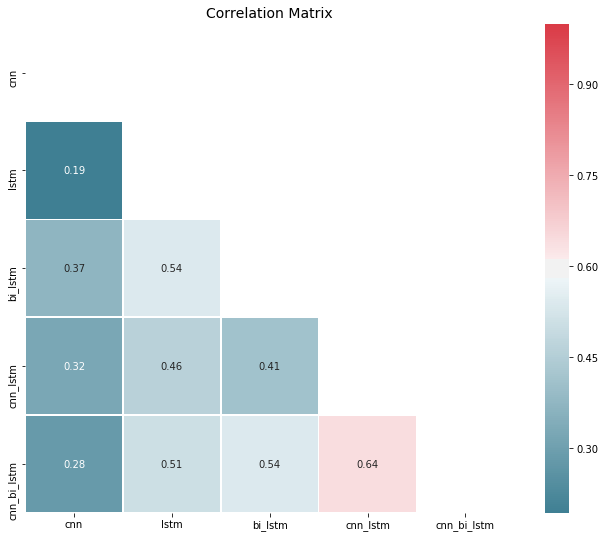

In [214]:
# corrmat(pred_df.corr(), inflate=False,show=False)
# plt.savefig('results/corr_matrix_base.png', bbox_inches='tight')
corrmat(pred_df.corr(), inflate=False)

## average

In [215]:
avg_pred_prob = pred_prob_base.mean(axis=2)

In [216]:
avg_pred_class = np.argmax(avg_pred_prob,axis=1)
avg_pred_class=avg_pred_class.astype(int)

In [217]:
acc = accuracy_score(testY,avg_pred_class)
acc

0.35

In [218]:
acc_results['average'] = acc

In [219]:
acc_results

{'average': 0.35,
 'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [22, 9, 15, 13],
  'incorrect_predicted_by_all': 37},
 'bi_lstm': 0.34,
 'cnn': 0.27,
 'cnn_bi_lstm': 0.4,
 'cnn_lstm': 0.26,
 'lstm': 0.3}

In [220]:
pred_df['average']=avg_pred_class

## Majority

In [221]:
majority_pred_class = [int(np.argmax(np.bincount(x))) for x in pred_class_base]

In [222]:
acc = accuracy_score(testY,majority_pred_class)
acc

0.36

In [223]:
acc_results['majority'] = acc

In [224]:
acc_results

{'average': 0.35,
 'base_model_counts': {'correct_predicted_by_all': 4,
  'correct_predicted_by_some': [22, 9, 15, 13],
  'incorrect_predicted_by_all': 37},
 'bi_lstm': 0.34,
 'cnn': 0.27,
 'cnn_bi_lstm': 0.4,
 'cnn_lstm': 0.26,
 'lstm': 0.3,
 'majority': 0.36}

In [225]:
pred_df['majority']=majority_pred_class

## Blend ensemble

In [229]:
seed=42

In [ ]:
baseX, devX, baseY, devY = train_test_split(trainX, trainY, test_size=0.10, random_state=42)

## Prediction Correlation

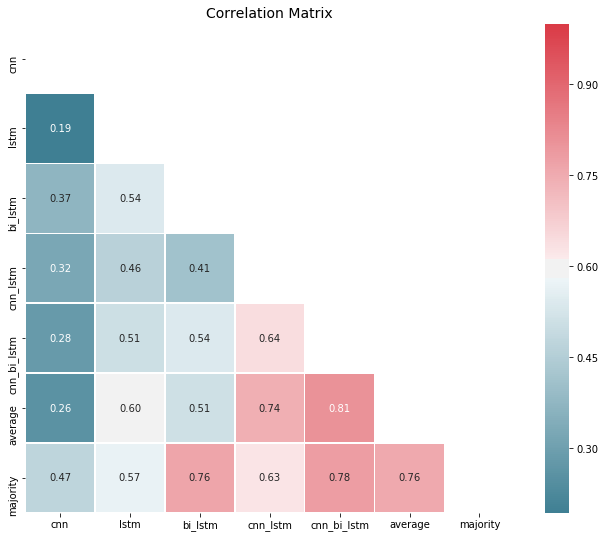

In [226]:
# corrmat(pred_df.corr(), inflate=False,show=False)
# plt.savefig('results/corr_matrix_full.png', bbox_inches='tight')
corrmat(pred_df.corr(), inflate=False)

## saving results

In [227]:
with open('results/ens_result.json','w') as fout:
    json.dump(acc_results,fout,indent=4)